In [82]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
import time
# !pip install uncertainties
import uncertainties
import datetime as dt
# !pip install lmfit
from lmfit import Model
import matplotlib.dates as mdates
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# # for plotting
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# %matplotlib ipympl
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams.update({'font.size': 14})
# plt.rcParams['figure.figsize'] = (6.66, 4)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main(raw_unix_time_flag = True)

# Time Constant of Detection Peak Tail

To determine the diffuse reflection probability the time constant of the exponential decay that occurs following the main detection peak, must be fitted. In the plots below we see the precise region of the time-of-flight spectrum that must be analyzed.

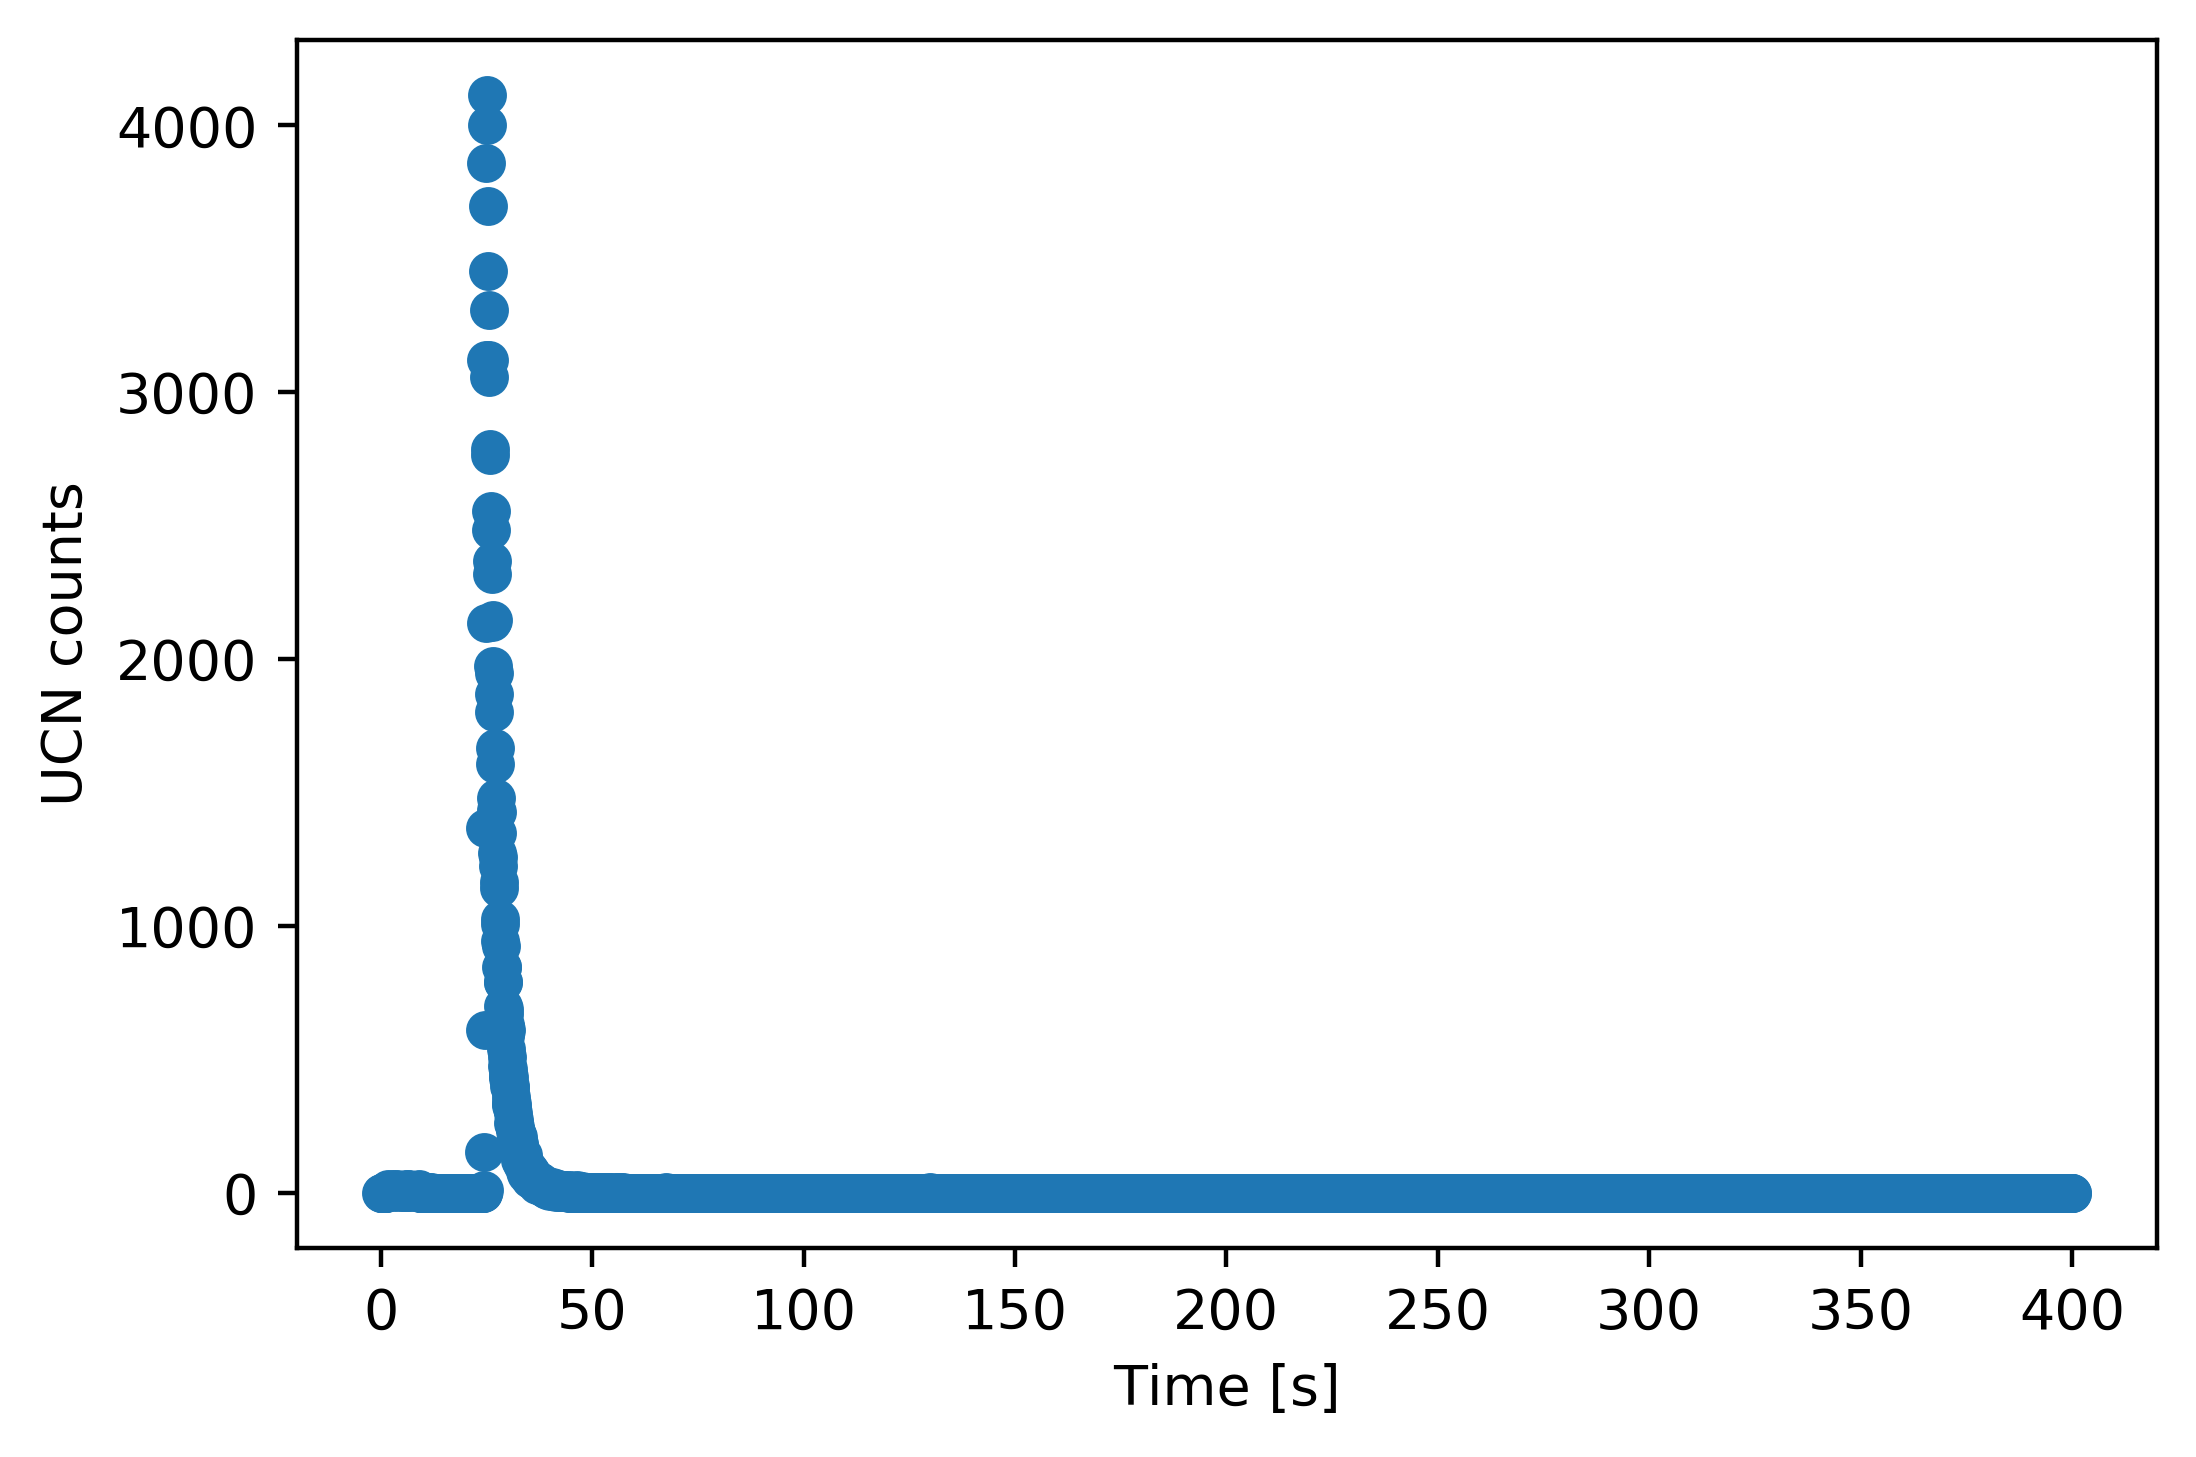

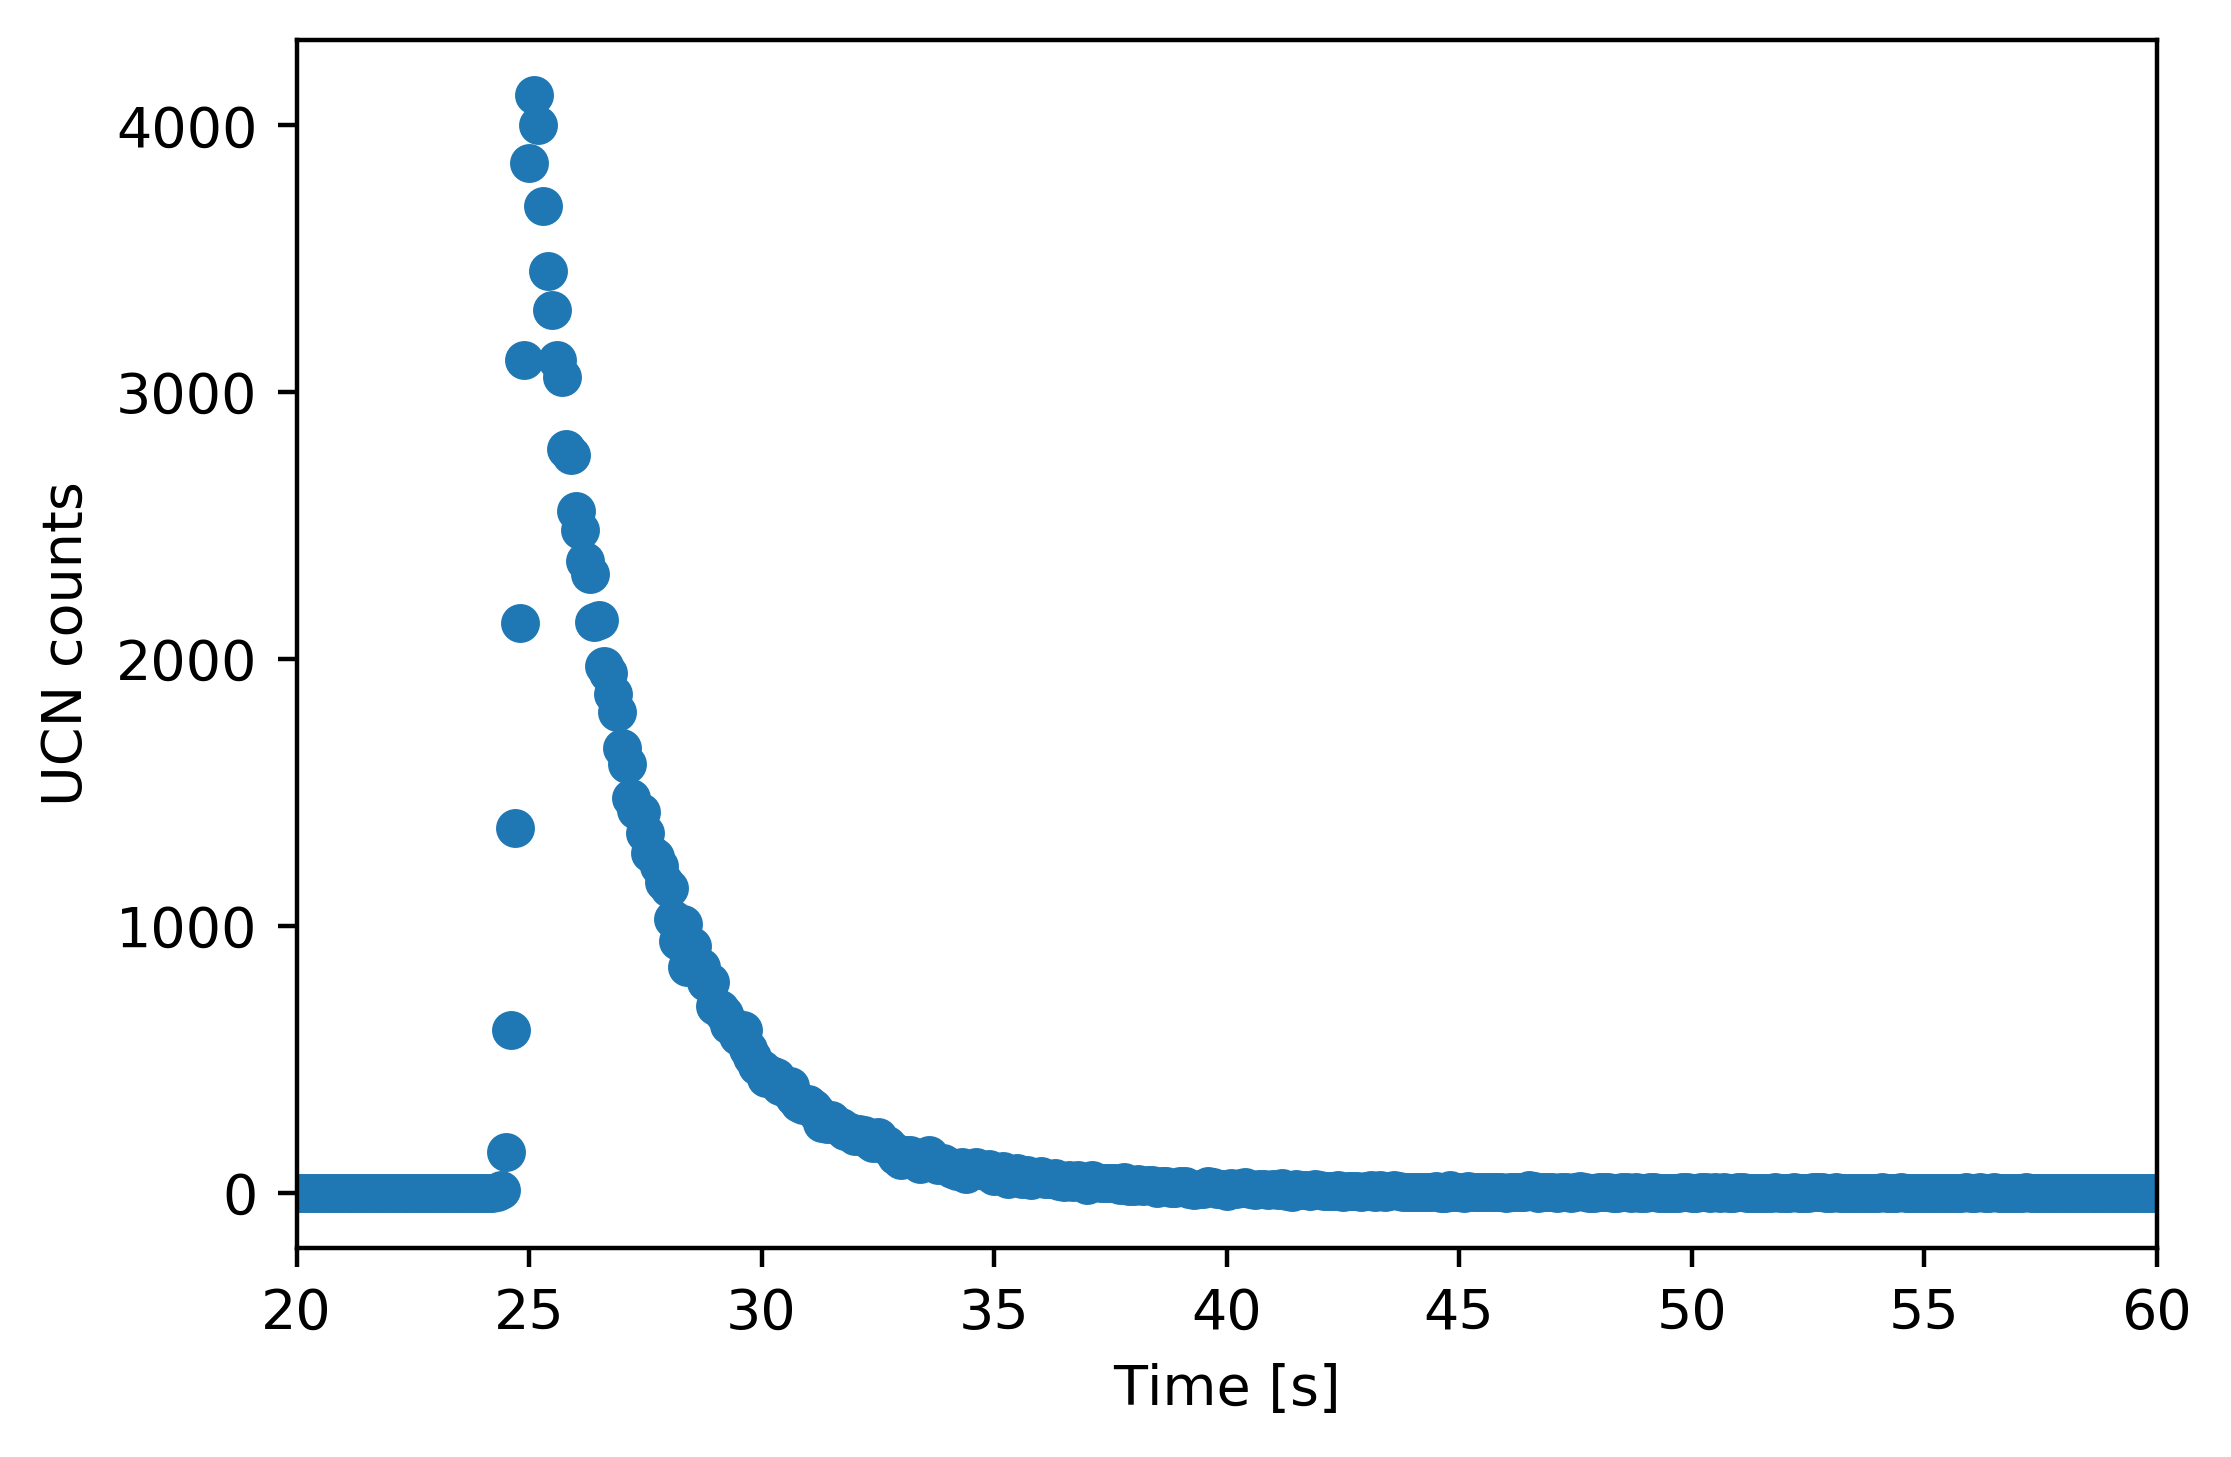

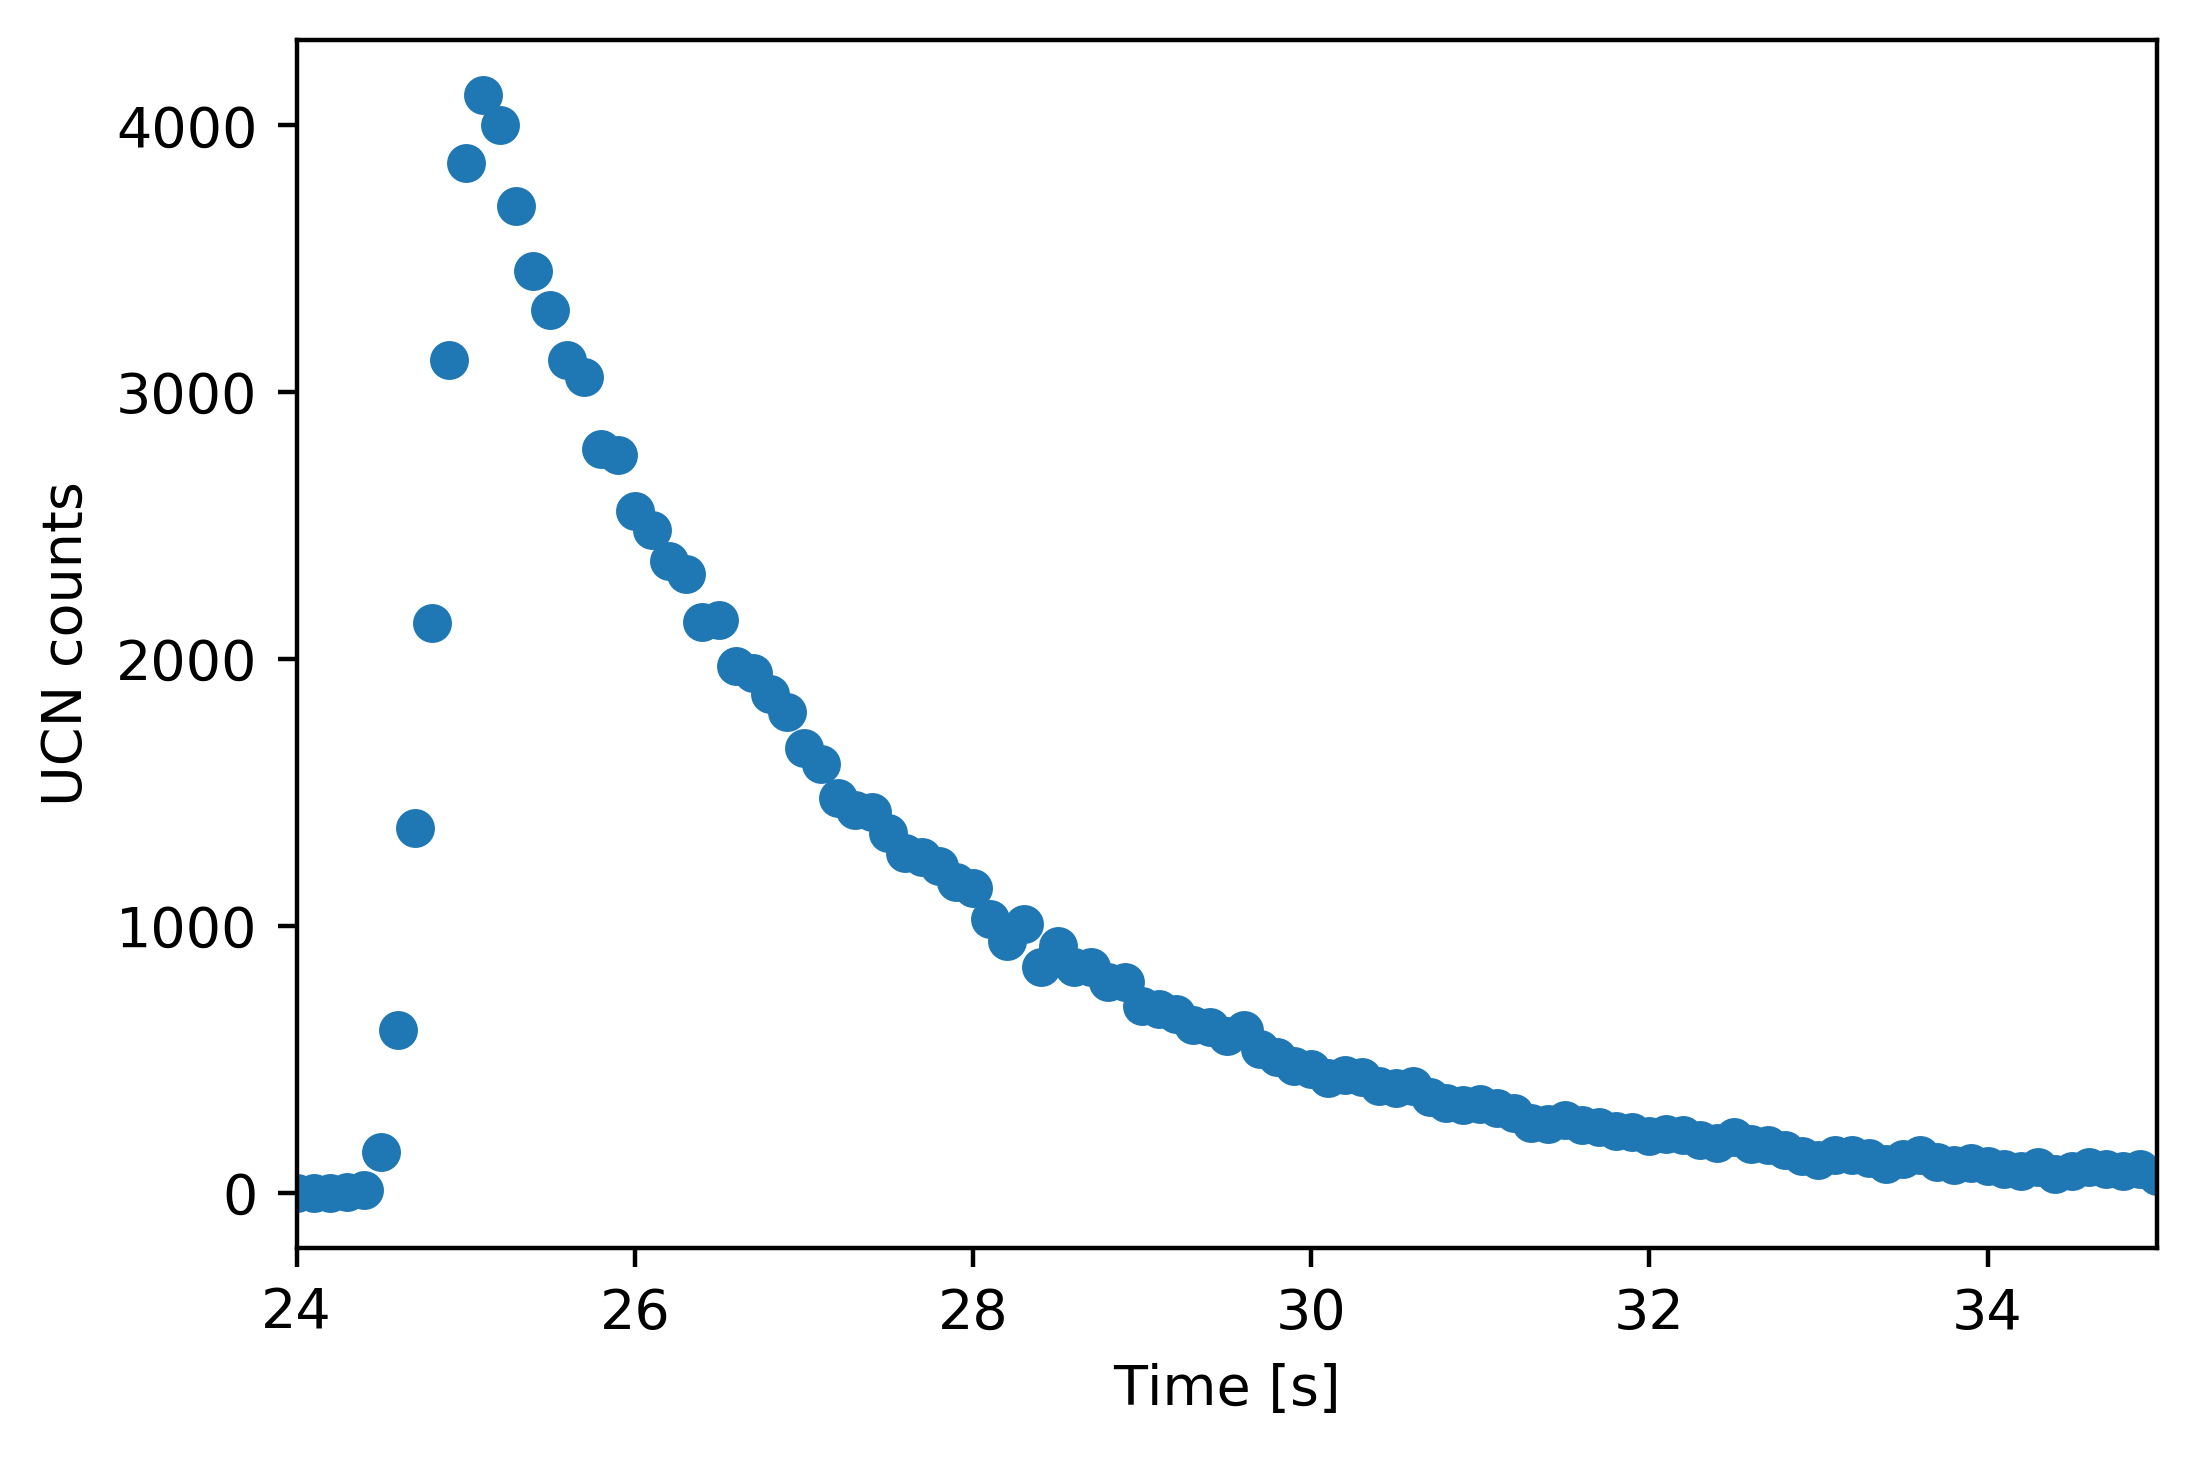

In [7]:
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()

data = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));
ax1.scatter(data[:,0] * 0.1, data[:,1]);
ax1.set_ylabel('UCN counts');
ax1.set_xlabel('Time [s]');

ax2.scatter(data[:,0] * 0.1, data[:,1]);
ax2.set_ylabel('UCN counts');
ax2.set_xlim([20,60])
ax2.set_xlabel('Time [s]');

ax3.scatter(data[:,0] * 0.1, data[:,1]);
ax3.set_ylabel('UCN counts');
ax3.set_xlim([24,35])
ax3.set_xlabel('Time [s]');

# Normalization Configurations

It is not yet clear whether or not the guided measurements will be sensitive to changes in the diffuse reflection probabilities of the guides themselves. To begin with, we'll fit decaying exponential functions to the data from the normalization runs. This will enable matching within the simulations, and the selection of diffuse reflection probability values for every material except that of the guides.

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 3749
    # variables        = 2
    chi-square         = 238838.073
    reduced chi-square = 63.7411457
    Akaike info crit   = 15578.4582
    Bayesian info crit = 15590.9167
[[Variables]]
    N_0:  2.4977e+08 +/- 3377725.30 (1.35%) (init = 6000)
    tau:  22.7095034 +/- 0.02661230 (0.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(N_0, tau) = -0.999



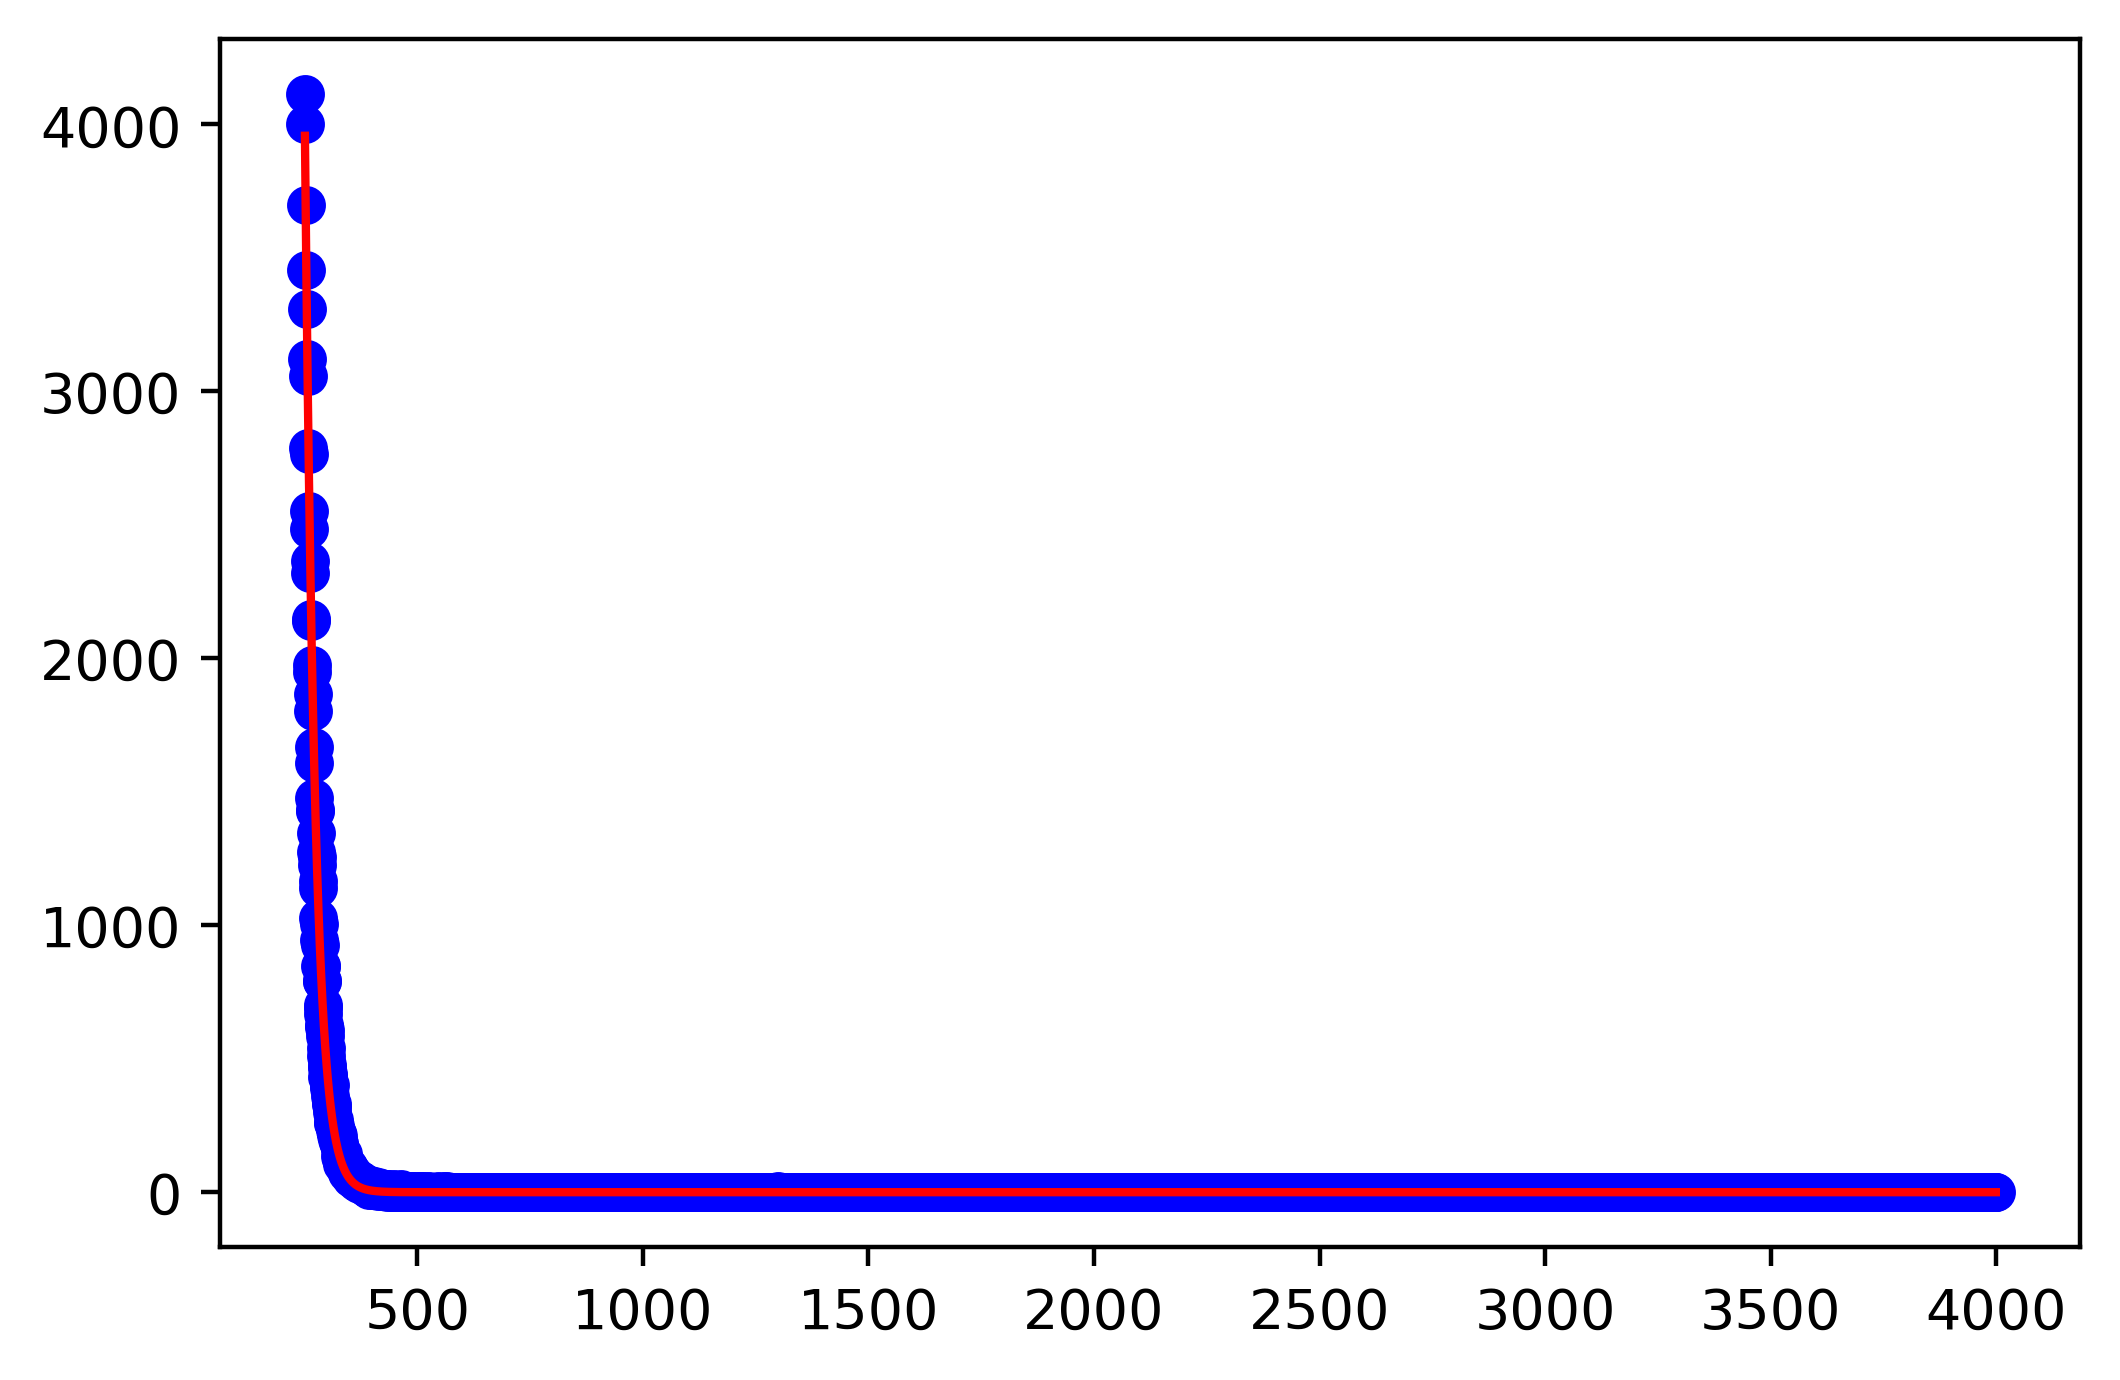

In [70]:
arr = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));

def decay(t, N_0, tau):
    return N_0 * np.exp(- t / tau)

### Using lmfit to perfom fit of source norm data
_counts = arr[:, 1]
max_index = _counts.argmax()
t = arr[max_index:-1, 0]
counts = _counts[max_index:-1]

gmodel = Model(decay)
# params = gmodel.make_params()
result = gmodel.fit(counts, t=t, N_0=6000, tau=20)

print(result.fit_report())
plt.plot(t, counts, 'bo')
# plt.plot(t, result.init_fit, 'k--')
plt.plot(t, result.best_fit, 'r-')
plt.show()

This method required a rather hand-wavy cut of the data. I'm just taking all of the data recorded after the maximum count value, and including that maximum value. This extremely rough approach should be reconsidered, and replaced with some kind of combined fit of the rising peak, and the ensuing decay. 

Now we perform this operation iteratively on every run carried out in the TRIUMF-style normalization configuration, and in the JP-style normalization configuration. The values for $\tau$ are averaged within each pre-storage-time-specific data set, and plotted below.

(NOMI,s005): 24.261+/-0.013
(NOMI,s020): 26.656+/-0.009
(NOMI,s100): 31.625+/-0.027
(DISK,s005): 27.494+/-0.018
(DISK,s020): 29.736+/-0.025
(DISK,s100): 34.06+/-0.08


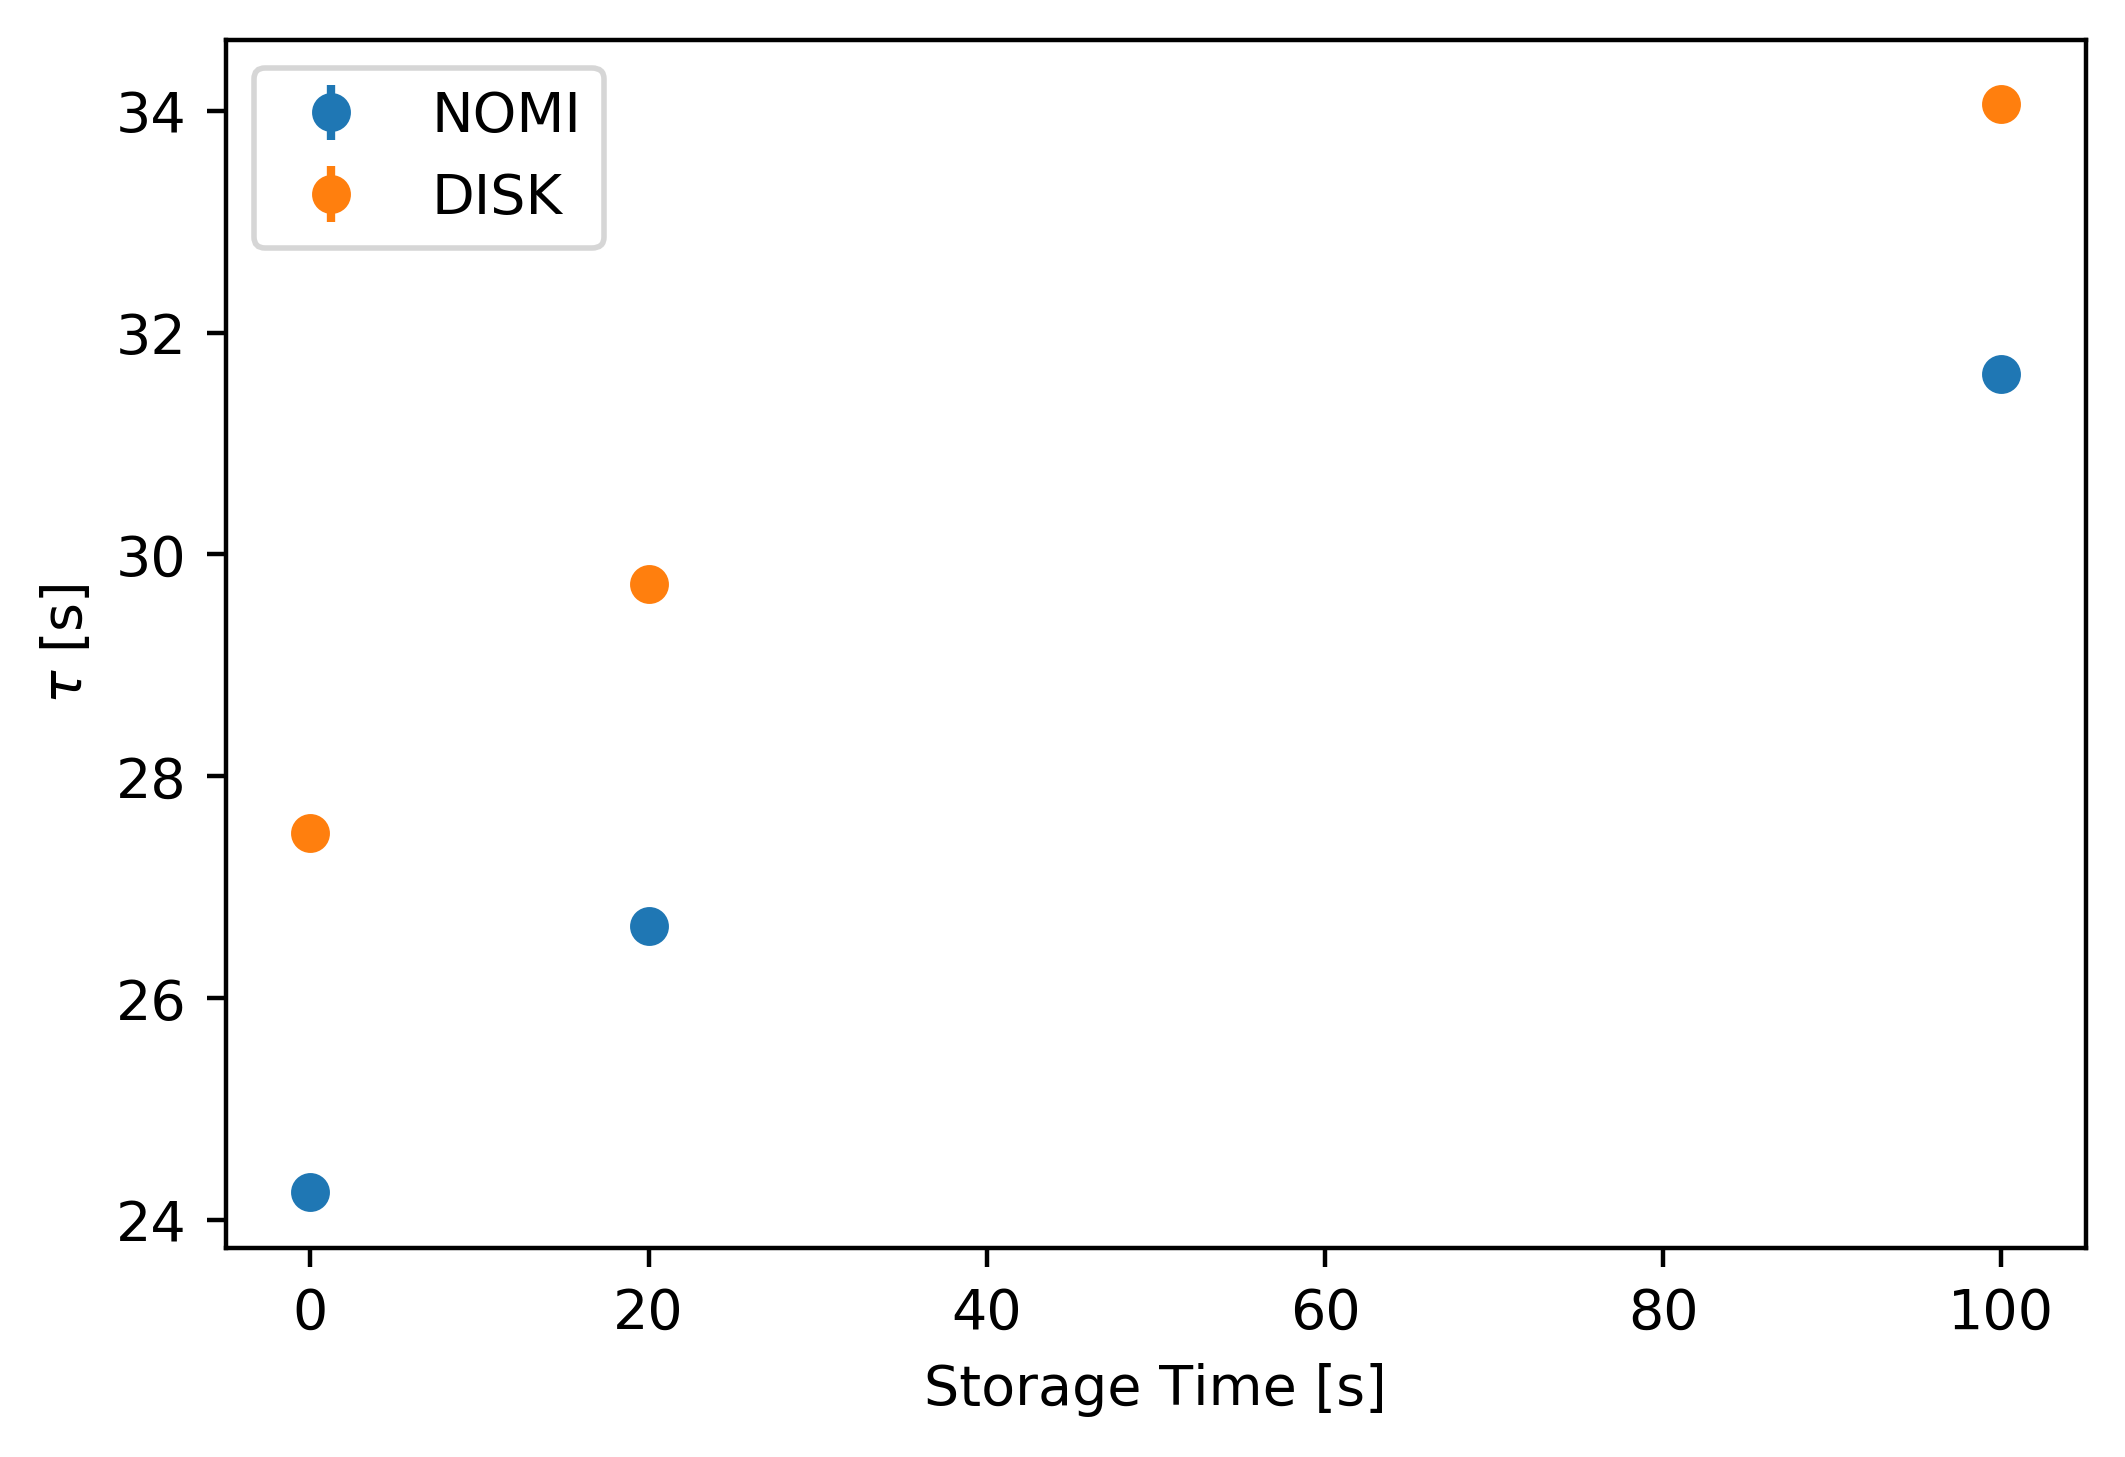

In [93]:
# dictionary to hold time constant values
tau_dict   = {} 

fig, ax = plt.subplots()
ax_c = plt.gca()

def decay(t, N_0, tau):
    return N_0 * np.exp(- t / tau)

for config in ['NOMI', 'DISK']:
    
    color = next(ax_c._get_lines.prop_cycler)['color']
    
    for run_type in ['s005', 's020', 's100']:
        
        # we'll save tau and error
        tau_dict[config, run_type] = np.empty((0,2), float)

        for filename in os.listdir('../data_ucn/main_detector_sorted'):

            # Only the files matching our desired configuration and run 
            # type are selected. The '.tof' condition is just so we 
            # don't perform the analysis twice per run (since it would
            # otherwise match to the .tof and the .txt files)
            if ((config in filename) and (run_type in filename) and 
            ('.tof' in filename)):

                # The data is retrieved from the .tof file
                arr = np.loadtxt('../data_ucn/main_detector_sorted/' + 
                                        filename[0:22] + '.tof',
                                        usecols = (0,1))
                
                _counts = arr[:, 1]
                max_index = _counts.argmax()
                t = arr[max_index:-1, 0]
                counts = _counts[max_index:-1]
                
                gmodel = Model(decay)
                result = gmodel.fit(counts, t=t, N_0=6000, tau=200)

#                 print(result.fit_report())
#                 plt.plot(t, counts, 'bo')
#                 plt.plot(t, result.best_fit, 'r-')
#                 plt.show()

                day_run_no = int(filename[1:3]) + (0.001
                                   * int(filename[9:12]))

                tau_dict[config, run_type] = np.append(
                    tau_dict[config, run_type], 
                    [[result.params['tau'].value, result.params['tau'].stderr]],
                    axis=0)
        
        # finished with given [config, run_type]
        # generate uncertainty array of data set, calculate mean, add to dict
        arr = tau_dict[config, run_type]
        uarr = unumpy.umatrix(arr[:,0], arr[:,1])
        ave_tau = uarr.mean(1)[0,0]

        storage_time = int(run_type[1:-1])

        # add mean value to plot
        # JP-style
        if (config == 'DISK'):

            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)

        # TRIUMF-style
        else:
            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)
            
        print('(' + config + ',' + run_type + '): {}'.format(ave_tau))
                               
# presentation stuff
ax.set_ylabel(r'$\tau$ [s]');
ax.set_xlabel('Storage Time [s]')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());    

## NOTE: These results have not used the source normalization at all, could this explain the depressed values for NOMI? NOMI represents the TRIUMF-style normalization measurements, which were carried out over the entire experimental campaign. Thus, they are more sensitive to the source decay that took place. Is this result consistent physically with what we expect happens to the energy spectrum due to the sD2 frost?

We can come back and perform the source normalization on this data, but for now this result can be used to fit the diffuse reflection probability. Any change due to the normalization will only change the probability value slightly, and also affect the error bar. We want to get quickly to the point where we can see if any of this matters for the guided measurements. 